<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.api as sm

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# Checking the top and bottom of the dataset
house.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [4]:
house.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
788,789,20,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,107900
784,785,75,RM,35.0,6300,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,128000
560,561,20,RL,NaN,11341,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,121500
72,73,60,RL,74.0,10141,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2009,WD,Normal,185000
902,903,60,RL,63.0,7875,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,180000


In [5]:
house.tail(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [6]:
# Dropping ID column as it does provide relevance to sales price prediction in our context

house.drop(columns=["Id"], axis=1, inplace=True)

In [7]:
house['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
house.shape

(1460, 80)

In [9]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [10]:
# Looking through unique values of each column
# A little harder to see here but I have used Excel for faster viewing

for col in house.columns:
    print(col, house[col].unique(),'\n')

MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40] 

MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH'] 

LotFrontage [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.] 

LotArea [ 8450  9600 11250 ... 17217 13175  9717] 

Street ['Pave' 'Grvl'] 

Alley [nan 'Grvl' 'Pave'] 

LotShape ['Reg' 'IR1' 'IR2' 'IR3'] 

LandContour ['Lvl' 'Bnk' 'Low' 'HLS'] 

Utilities ['AllPub' 'NoSeWa'] 

LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'] 

LandSlope ['Gtl' 'Mod' 'Sev'] 

Neig

In [11]:
# Check for missing values

num_count = []

# List created to show the Null values of each column

for col in house.columns:
    if house[col].isnull().sum() != 0:
        num_count.append([col, house[col].isnull().sum()])


         Columns  Nulls
16        PoolQC   1453
18   MiscFeature   1406
1          Alley   1369
17         Fence   1179
10   FireplaceQu    690
0    LotFrontage    259
11    GarageType     81
12   GarageYrBlt     81
13  GarageFinish     81
14    GarageQual     81
15    GarageCond     81
6   BsmtExposure     38
8   BsmtFinType2     38
7   BsmtFinType1     37
5       BsmtCond     37
4       BsmtQual     37
3     MasVnrArea      8
2     MasVnrType      8
9     Electrical      1


Text(0.5, 1.0, 'NA Value Counts')

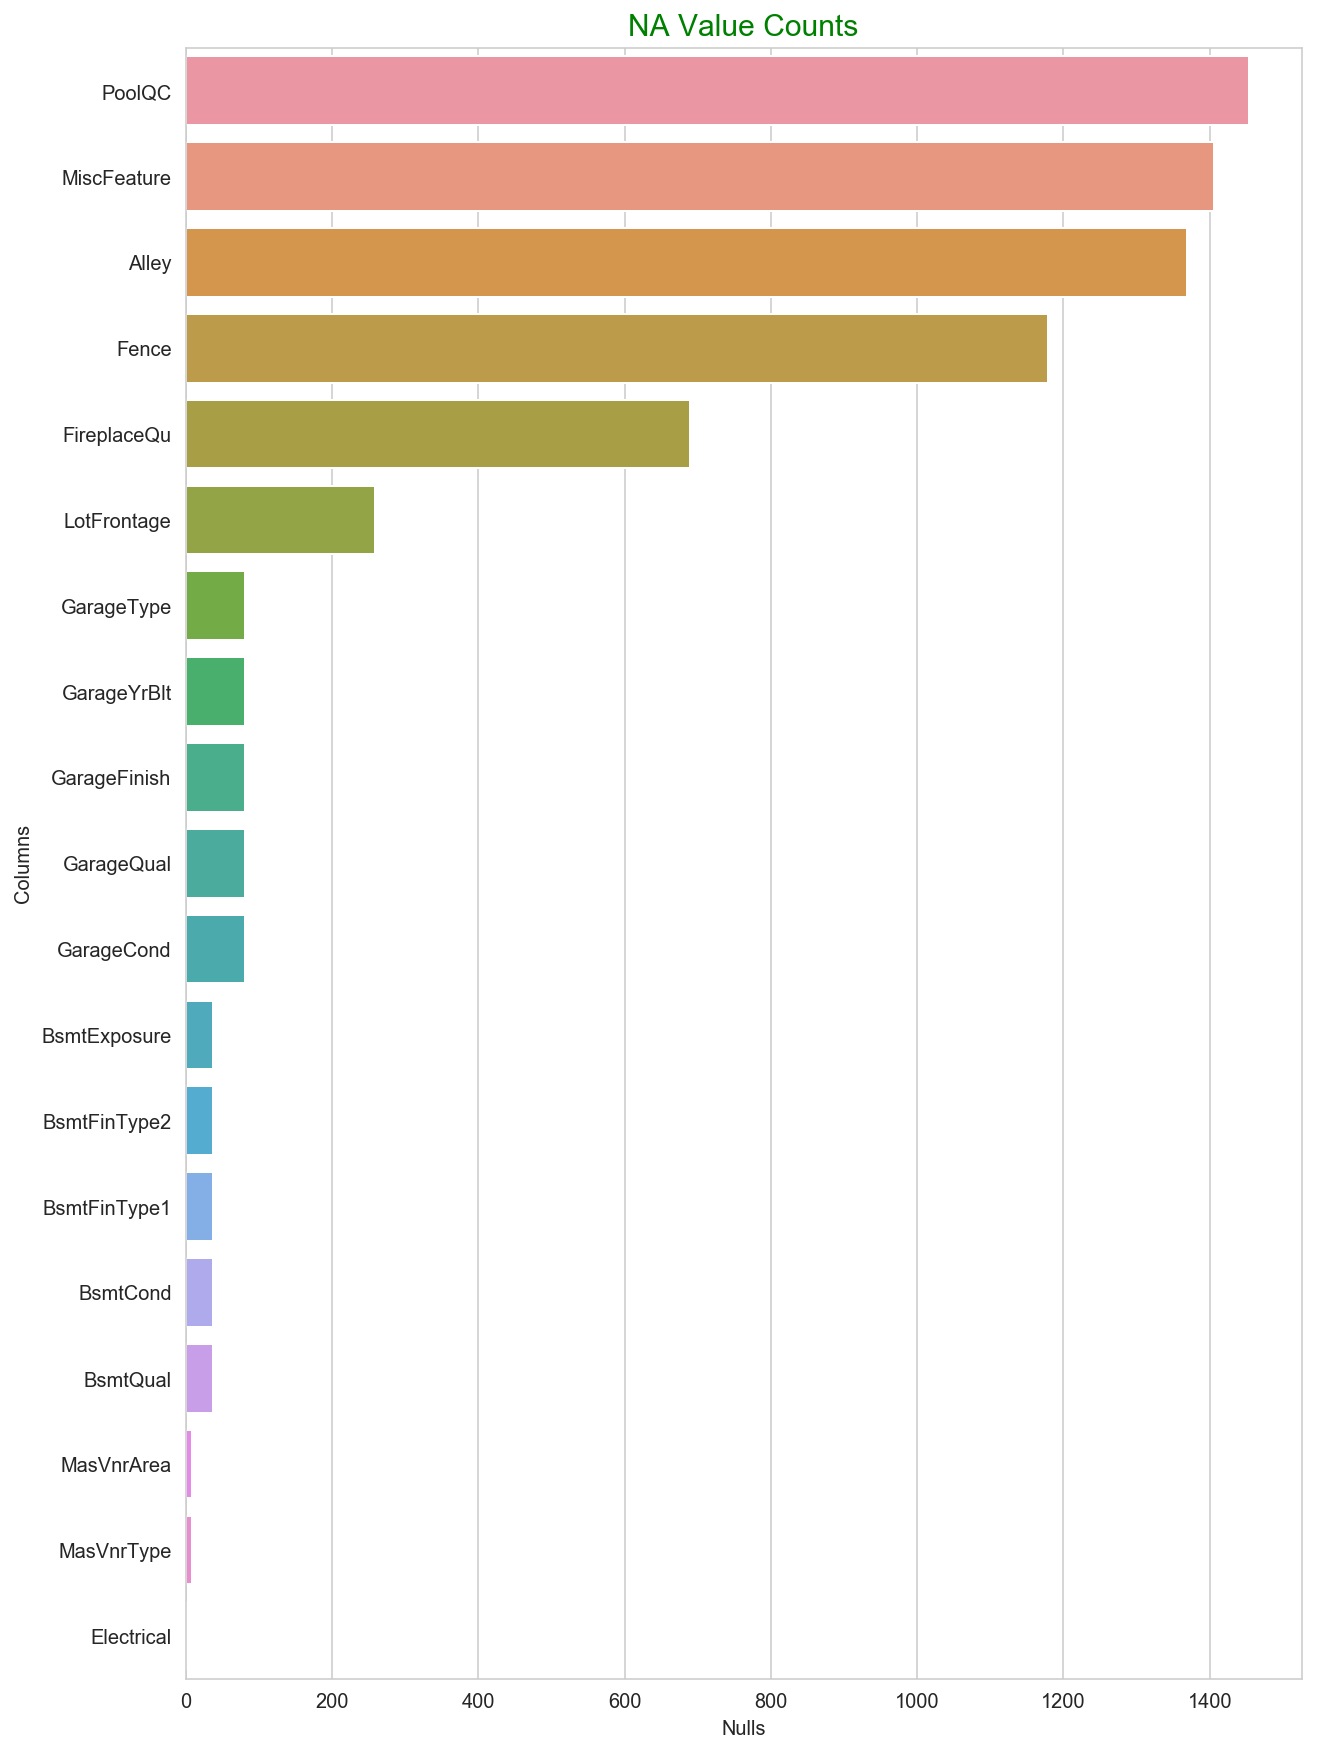

In [12]:
num = pd.DataFrame(num_count, columns=['Columns', 'Nulls'])
null = num.sort_values('Nulls',ascending=False)

print(null)

fig, ax = plt.subplots(figsize=(10,15))
ax = sns.barplot(x="Nulls", y="Columns", data=null)
ax.set_title('NA Value Counts',size=15,color='Green')

In [13]:
# After understanding each column from the description text file, most of the columns with NA values do have a meaning (except LotFrontage).
# E.g. Columns: GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond are NaN due to the lack of Garage.
# Renaming the null columns to better reflect what they stand for

house['PoolQC'].fillna('No_Pool', inplace=True)
house['MiscFeature'].fillna('No_Features', inplace=True)
house['Alley'].fillna('No_Alley', inplace=True)
house['Fence'].fillna('No_Fence', inplace=True)
house['FireplaceQu'].fillna('No_Fireplace', inplace=True)
house['GarageType'].fillna('No_Garage', inplace=True)
house['GarageYrBlt'].fillna('No_Garage', inplace=True)
house['GarageFinish'].fillna('No_Garage', inplace=True)
house['GarageQual'].fillna('No_Garage', inplace=True)
house['GarageCond'].fillna('No_Garage', inplace=True)
house['BsmtFinType2'].fillna('No_Bsmt', inplace=True)
house['BsmtFinType1'].fillna('No_Bsmt', inplace=True)
house['BsmtCond'].fillna('No_Bsmt', inplace=True)
house['BsmtQual'].fillna('No_Bsmt', inplace=True)
house['MasVnrArea'].fillna('No_Mas', inplace=True)
house['MasVnrType'].fillna('No_Mas', inplace=True)

In [14]:
# LotFrontage column is a continuous variable which does not have an NA value.
# Looking at rows of NA LotFrontage

house[house['LotFrontage'].isnull()].sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
840,70,RH,NaN,12155,Pave,No_Alley,IR1,Lvl,AllPub,Inside,...,0,No_Pool,No_Fence,No_Features,0,3,2008,WD,Normal,140000
361,50,RL,NaN,9144,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,No_Pool,No_Fence,No_Features,0,7,2008,WD,Normal,145000
384,60,RL,NaN,53107,Pave,No_Alley,IR2,Low,AllPub,Corner,...,0,No_Pool,No_Fence,No_Features,0,6,2007,WD,Normal,240000
1138,20,RL,NaN,9819,Pave,No_Alley,IR1,Lvl,AllPub,Inside,...,0,No_Pool,No_Fence,No_Features,0,5,2009,WD,Normal,196000
1251,120,RL,NaN,3136,Pave,No_Alley,IR1,Lvl,AllPub,Corner,...,0,No_Pool,No_Fence,No_Features,0,3,2006,WD,Normal,171750


In [15]:
# Check if LotFrontage is correlated to any other variables for prediction 

house[house.columns[:]].corr()['LotFrontage'].sort_values(ascending=False)[:5]

# The top five highest correlated variables to LotFrontage do not have a high enough correlation for us to predict missing values

LotFrontage    1.000000
1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
TotalBsmtSF    0.392075
Name: LotFrontage, dtype: float64

In [16]:
# Alternative is to change all null LotFrontage values to the median LotFrontage variable

house.LotFrontage = house.LotFrontage.fillna(house.LotFrontage.median())

In [17]:
house.LotFrontage.isnull().sum() # Checking if null values still exist

0

/Users/ivanong/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


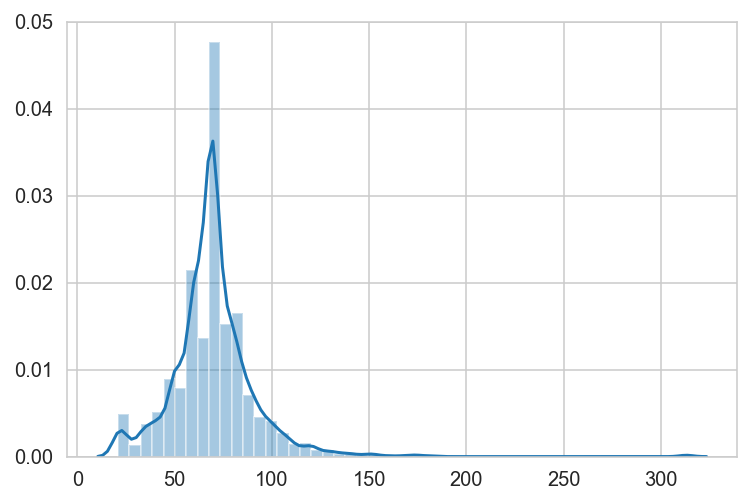

In [18]:
# Plotting all non-null values of LotFrontage to look at the distribution
lot_dist = []
for i in house['LotFrontage']:
    if i>=1:
        lot_dist.append(i)
        
sns.distplot(lot_dist)

In [19]:
# From the above distribution, it seems normal enough so the decision is to replace all null values with the median

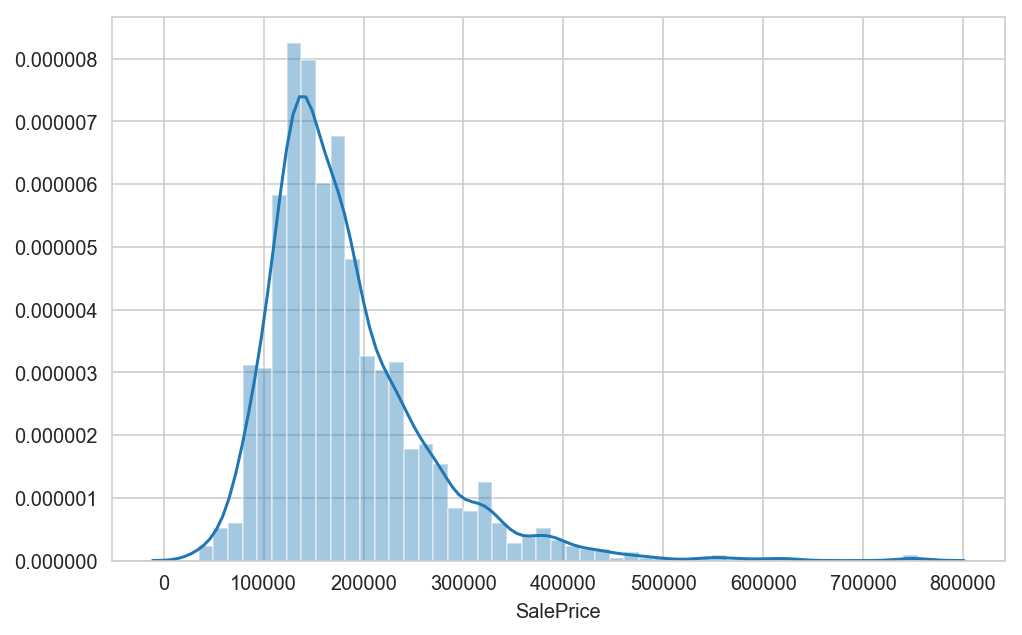

In [20]:
# Looking at the SalePrice distribution
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(house['SalePrice'])

# Comments on the distribution below:
# SalePrice has a right skewed distribution

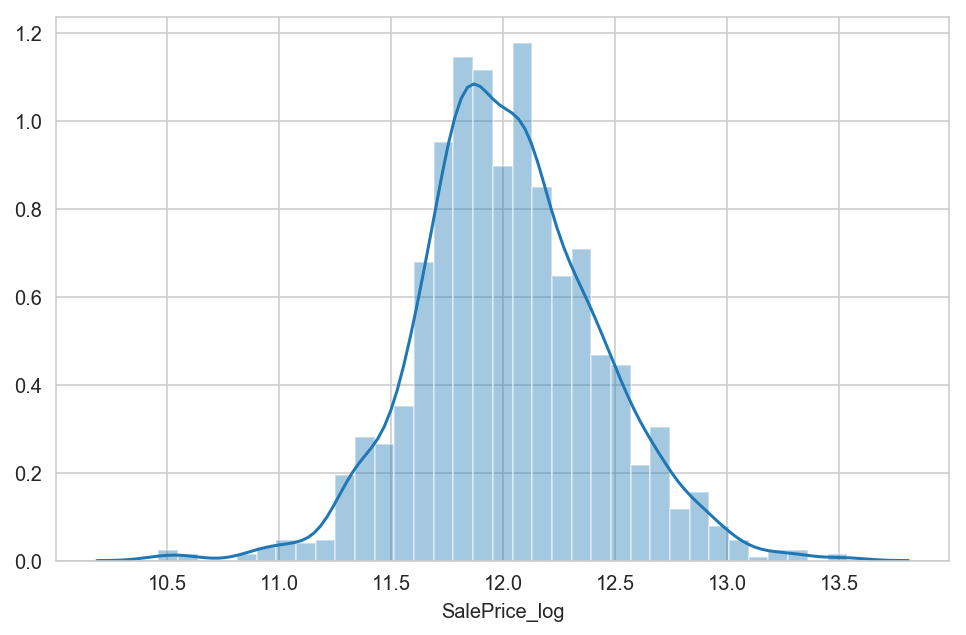

In [21]:
# Log normalizing SalePrice

house['SalePrice_log'] = np.log1p(house[["SalePrice"]])
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(house['SalePrice_log'])

In [22]:
# Filtering MSZoning for residential housing only

house = house.loc[(house['MSZoning'] != 'A') & (house['MSZoning'] != 'C') & (house['MSZoning'] != 'I') & (house['MSZoning'] != 'C (all)')]

In [23]:
house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [24]:
house[house.columns[1:]].corr()['SalePrice'][:-1].sort_values(ascending=False)

# From the results below:

# OverallQual, GrLivArea, GarageCars, GarageArea andn Total BsmtSF 
# seems to have strong positive correlation with SalePrice

# Fixed features that can predict prices are GrLivArea, GarageCars, GarageArea, TotalBsmtSF and 1stFlrSF.
# Note: GarageCars and GarageArea are variables that are correlated.

SalePrice        1.000000
OverallQual      0.789031
GrLivArea        0.708658
GarageCars       0.642135
GarageArea       0.629831
TotalBsmtSF      0.612088
1stFlrSF         0.603300
FullBath         0.556674
TotRmsAbvGrd     0.533355
YearBuilt        0.517602
YearRemodAdd     0.501186
Fireplaces       0.463264
BsmtFinSF1       0.384475
LotFrontage      0.337514
OpenPorchSF      0.329491
WoodDeckSF       0.320770
2ndFlrSF         0.319774
HalfBath         0.280882
LotArea          0.264715
BsmtFullBath     0.224054
BsmtUnfSF        0.216152
BedroomAbvGr     0.162008
ScreenPorch      0.110540
PoolArea         0.092396
MoSold           0.051987
3SsnPorch        0.043807
BsmtFinSF2      -0.014145
BsmtHalfBath    -0.017561
LowQualFinSF    -0.018755
MiscVal         -0.021052
YrSold          -0.025391
OverallCond     -0.089084
EnclosedPorch   -0.120765
KitchenAbvGr    -0.137825
Name: SalePrice, dtype: float64

In [25]:
house[['GarageCars','GarageArea']].corr()

,GarageCars,GarageArea
GarageCars,1.000000,0.883009
GarageArea,0.883009,1.000000


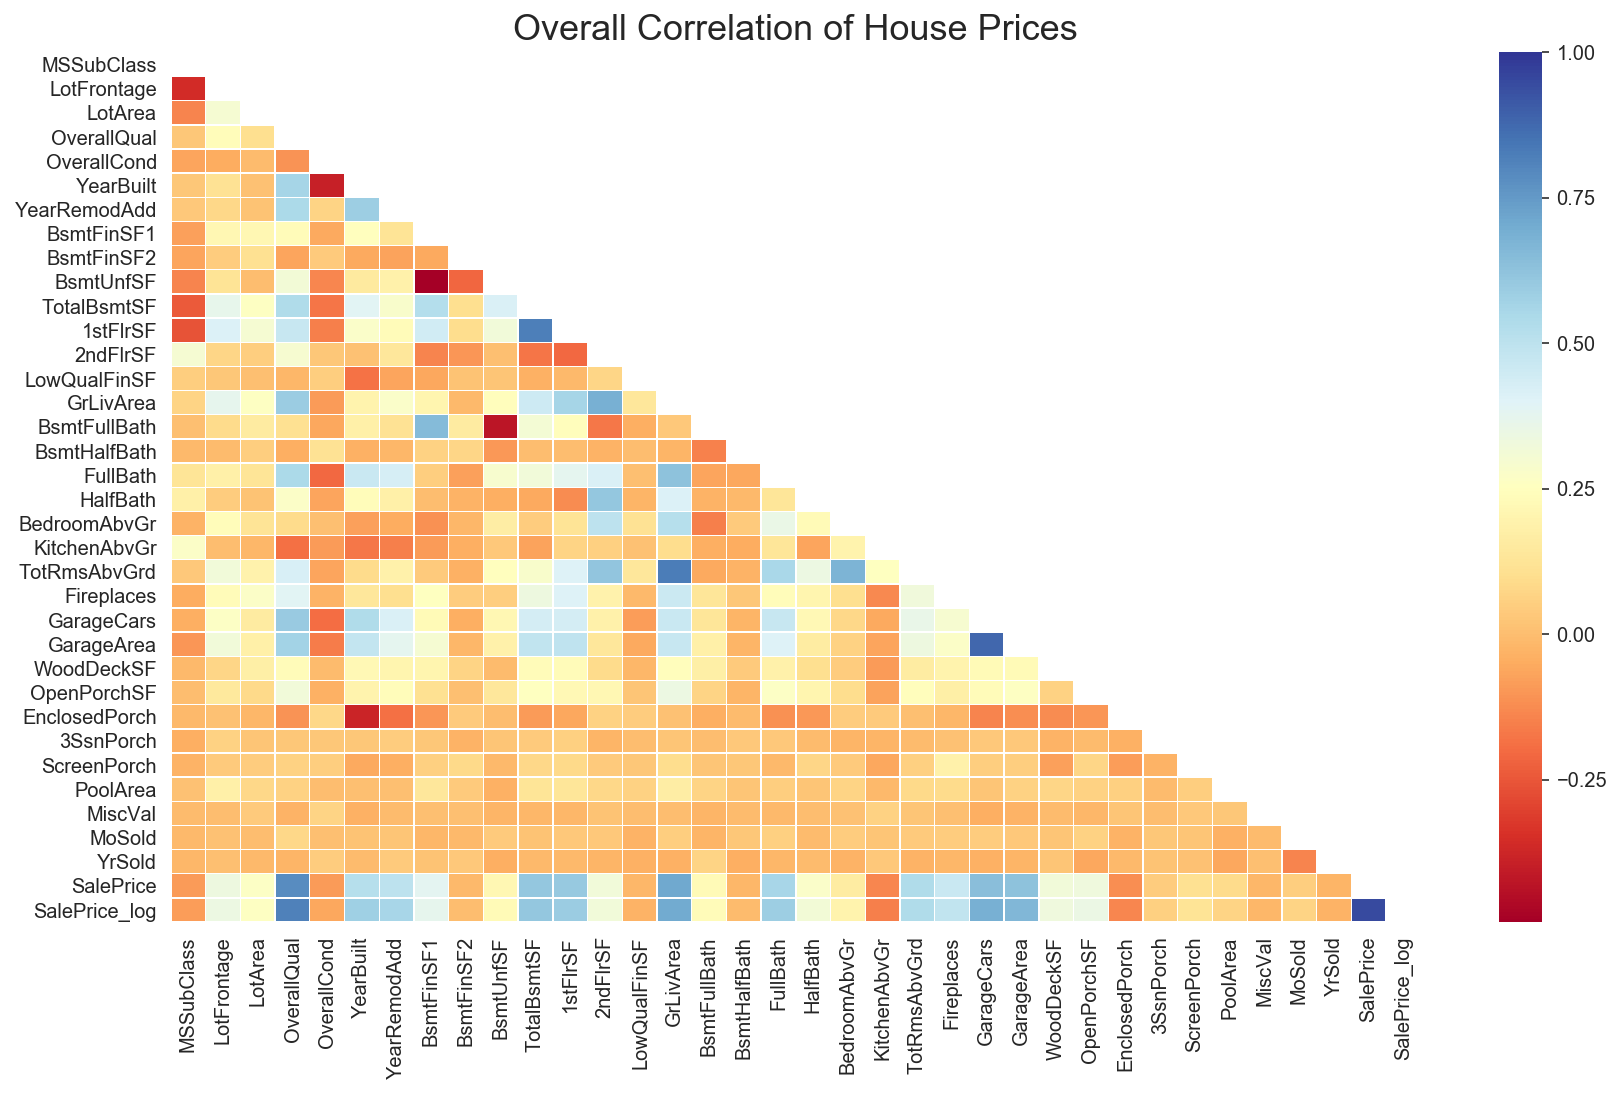

In [26]:
corr = house.corr()
plt.figure(figsize=(14,8))
mask = np.zeros_like(house.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.title('Overall Correlation of House Prices', fontsize=18)
sns.heatmap(corr,annot=False, mask=mask, cmap='RdYlBu',linewidths=0.2,annot_kws={'size':20})
plt.show()

### From the Heatmap above:
- It can be seen that some variables are highly correlated to each other. One example being: GarageArea and GarageCars
- However, I have decided to not drop any columns at this stage but rather allow the models to perform feature selection and examine the results

In [27]:
# Creating a list to filter fixed features of dataframe

fixed_features = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood' , 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd',  'BedroomAbvGr', 'KitchenAbvGr', 'Foundation', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MoSold', 'YrSold', 'SalePrice', 'SalePrice_log']

In [28]:
# Subsetting the house 
house_fixed = house[[c for c in house.columns if c in fixed_features]]

In [29]:
house_fixed['YrSold'].unique()

array([2008, 2007, 2006, 2009, 2010])

### Performing Train, Test, Split

In [30]:
# Columns with numerical data types

print(house_fixed.get_dtype_counts())
house_fixed.dtypes[house.dtypes != "object"]

int64      31
object     18
float64     2
dtype: int64


MSSubClass         int64
LotFrontage      float64
LotArea            int64
YearBuilt          int64
YearRemodAdd       int64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MoSold             int64
YrSold             int64
SalePrice          int64
SalePrice_log    float64
dtype: object

In [31]:
# And columns with non-numeric types
house_fixed.dtypes[house.dtypes == "object"]

MSZoning        object
Street          object
Alley           object
LotShape        object
LandContour     object
LotConfig       object
LandSlope       object
Neighborhood    object
Condition1      object
Condition2      object
BldgType        object
HouseStyle      object
Foundation      object
BsmtExposure    object
GarageType      object
GarageYrBlt     object
PavedDrive      object
MiscFeature     object
dtype: object

In [32]:
# Storing non-numerics in a list

non_numerical = [x for x in house_fixed.columns \
                if not (house_fixed[x].dtype == np.float64 \
                        or house_fixed[x].dtype == np.int64)]

In [33]:
print(non_numerical)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtExposure', 'GarageType', 'GarageYrBlt', 'PavedDrive', 'MiscFeature']


In [34]:
numerical = [x for x in house_fixed.columns \
                if (house_fixed[x].dtype == np.float64 \
                        or house_fixed[x].dtype == np.int64)]

In [35]:
print(numerical)

['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold', 'SalePrice', 'SalePrice_log']


In [36]:
house_fixed.shape

(1450, 51)

In [37]:
# Fixed features of a home to estimate home value

num_cols = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF',
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
        'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold',
         'SalePrice_log']

dummies = pd.get_dummies(house_fixed[['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
                                      'BldgType', 'HouseStyle', 'Foundation']])

df = pd.concat([house_fixed[num_cols],dummies,], axis=1)

In [38]:
df.shape

(1450, 94)

In [39]:
# Setting up the target and predictor matrix

y_train = df[df['YrSold']<2010] ['SalePrice_log']
y_test = df[df['YrSold']==2010] ['SalePrice_log']

In [40]:
# Removing SalePrice for X_train and X_test
df = df.drop(columns=['SalePrice_log'])

X_train = df[df['YrSold']<2010]
X_test = df[df['YrSold']==2010]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1278, 93)
(172, 93)
(1278,)
(172,)


In [41]:
# Standardise the predictor data

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/ivanong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


### Using 2 models: Lasso and RFE to determine best variables in predicting SalePrice

In [42]:
# Using Lasso for feature selection

optimal_lasso = LassoCV (n_alphas=500, cv=5)
optimal_lasso.fit(X_train, y_train)
print('Optimal Lasso Alpha:', optimal_lasso.alpha_)

# Cross-validate the Lasso regression  R2  with the optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_test, y_test, cv=10)

print('Lasso scores:', lasso_scores)
print('Lasso mean score:', np.mean(lasso_scores))

Optimal Lasso Alpha: 0.004703993568742905
Lasso scores: [0.86208592 0.79272198 0.86991364 0.86070494 0.81039943 0.93518463
 0.84636766 0.94305772 0.81416676 0.8708798 ]
Lasso mean score: 0.8605482488293603


##### Lasso provided a mean score of 0.86055

In [43]:
# Look at the coefficients for variables in Lasso

lasso.fit(X_test, y_test)
y_pred_lasso = lasso.predict(X_test)

lasso_coefs = pd.DataFrame({'Column':df.columns,
                            'Coefficient':lasso.coef_,})

lasso_coefs.sort_values('Coefficient', inplace=True, ascending=False)

lasso_coefs.head(10) # Top 10 coefficients

,Column,Coefficient
2,YearBuilt,0.099809
10,GrLivArea,0.090113
18,GarageArea,0.071190
55,Neighborhood_Crawfor,0.053422
4,BsmtFinSF1,0.048668
7,1stFlrSF,0.036729
89,Foundation_PConc,0.036319
53,Neighborhood_ClearCr,0.030713
65,Neighborhood_NridgHt,0.030601
3,YearRemodAdd,0.029078


- From the above table, it can be seen that YearBuilt, GrLivArea, GarageArea, Neighborhood and BsmtFinSF1 are the top 5 predictors which influence house SalePrice predictions

In [44]:
# Total count for coefficients are 29 from Lasso
lasso_coefs[lasso_coefs['Coefficient']>0].count()

Column         29
Coefficient    29
dtype: int64

In [45]:
lasso_list = list(lasso_coefs[lasso_coefs['Coefficient']>0] ['Column']) # Creating a list for all uneliminated Lasso coefficients

In [46]:
# Using RFEcv for feature selection

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10, n_jobs=-1, verbose=1)
selector = selector.fit(X_train, y_train)

In [47]:
rfecv_list = df.columns[selector.support_]
rfecv_list

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MoSold', 'YrSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod',
       'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_

- From the above RFE function, the top predictors that were present in Lasso are YearBuilt, BsmtFinSF1, GrLivArea.
- Other top predictors chosen by RFE are LotFrontage, LotArea and YearRemodAdd.

In [48]:
len(rfecv_list) # RFEcv kept 93 features. More features were eliminated by the Lasso Method.

93

## On to scoring the models with the features selected by Lasso

##### Model 1: Linear Regression

In [49]:
X_train = df[df['YrSold']<2010]
X_test = df[df['YrSold']==2010]
X_train = X_train[[i for i in lasso_list]]
X_test = X_test[[i for i in lasso_list]]

In [50]:
lr = LinearRegression()


lr_model = lr.fit(X_train, y_train)

In [51]:
# Cross val R2 score for training data

scores = cross_val_score(lr, X_train, y_train, cv = 10)
print(scores)
print('Mean R2 score: ',np.mean(scores))
print('The standard deviation is:', np.std(scores))

[0.88450413 0.86885385 0.86408207 0.76221098 0.86936638 0.85635733
 0.82219411 0.86327886 0.44468601 0.85518684]
Mean R2 score:  0.8090720543495886
The standard deviation is: 0.12584576147203136


In [52]:
# Scoring with test data
y_hat = lr_model.predict(X_test)

print('R2 score when tested with test data: ',(lr_model.score(X_test, y_test)))
print('RMSE score is: ', (np.sqrt(mean_squared_error(y_hat, y_test))))

R2 score when tested with test data:  0.8816607477585435
RMSE score is:  0.13542824550298177


##### Model 2: Ridge Regression

In [53]:
ridge_alphas = np.logspace(0,5,200)

#Finding the optimal ridge alpha 
optimal_ridge = RidgeCV(alphas = ridge_alphas, cv = 10)
optimal_ridge.fit(X_train, y_train)


ridge = Ridge(alpha = optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, X_train, y_train, cv = 10)

print(ridge_scores)
print('Mean R2 score:',(np.mean(ridge_scores)))
print('The standard deviation is:' , np.std(ridge_scores))

[0.88506483 0.86937839 0.86504649 0.76232206 0.86976737 0.85780289
 0.82337868 0.86263794 0.44042484 0.85624646]
Mean R2 score: 0.809206996769724
The standard deviation is: 0.127274925234547


/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [54]:
# Scoring with test data

ridge.fit(X_train, y_train)
y_hat = ridge.predict(X_test)

print('R2 score when tested with test data:', ridge.score(X_test, y_test))
print('RMSE score is: ',(np.sqrt(mean_squared_error(y_hat, y_test))))

R2 score when tested with test data: 0.881626066453322
RMSE score is:  0.13544808881007667


##### Model 3: Lasso Regression

In [55]:
optimal_lasso = LassoCV(n_alphas = 50, cv = 10)
optimal_lasso.fit(X_train, y_train)

lasso = Lasso(alpha = optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv = 10)

print(lasso_scores)
print('Mean R2 score from the training data:', np.mean(lasso_scores))
print('The standard deviation is:',np.std(lasso_scores))

[0.84349978 0.84158437 0.84521065 0.71264015 0.82620742 0.8419769
 0.7961137  0.78591633 0.20041529 0.81900569]
Mean R2 score from the training data: 0.7512570280907485
The standard deviation is: 0.1876336456994828


In [56]:
# Scoring with test data
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)

print('Mean R2 score with test data:' ,lasso.score(X_test, y_test))
print('RSME score is:', np.sqrt(mean_squared_error(y_hat, y_test)))

Mean R2 score with test data: 0.8300216297956373
RSME score is: 0.16230865248181006


##### Model 4: Elastic Net

In [57]:
enet_ratios = np.linspace(0.01, 1.0, 50)

optimal_enet = ElasticNetCV(l1_ratio = enet_ratios, n_alphas = 100, cv = 10)
optimal_enet.fit(X_train, y_train)

enet = ElasticNet(alpha = optimal_enet.alpha_, l1_ratio = optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, X_train, y_train, cv = 10)

print(enet_scores)
print('The mean cross validated R2 score for the training:',np.mean(enet_scores))
print('The standard deviation is:', np.std(enet_scores))

[0.84349112 0.84157778 0.84525924 0.71260783 0.82627753 0.84201839
 0.79615832 0.78593616 0.20020078 0.81900017]
The mean cross validated R2 score for the training: 0.7512527318829345
The standard deviation is: 0.1877050172235101


In [58]:
# Scoring with the test data
enet.fit(X_train, y_train)
y_hat = enet.predict(X_test)

print('R2 score when tested with test data is:',(enet.score(X_test, y_test)))
print('Root mean squared error score is:' ,(np.sqrt(mean_squared_error(y_hat, y_test))))

R2 score when tested with test data is: 0.8300562170495873
Root mean squared error score is: 0.16229213833304226


#### Question 1 Conclusion
Based on scores from testing data:
- Linear Regression model provided the highest R2 score of 0.88166
- Followed closely with Ridge which had a R2 score of 0.881626

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [59]:
# A:

# From Question 1, we saw that fixed characteristics have been able to predict 88% of the variance in sales price.
# We now aim to explain the remaining 12% from the variable features.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

#### Perform some EDA for renovatable variables

In [60]:
# Subsetting the non-fixed features
# Including SalePrice_log for testing
fixed_features = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood' , 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MoSold', 'YrSold','SalePrice_log']

house_variables = house[[c for c in house.columns if c not in fixed_features]]

In [61]:
house_variables.shape

(1450, 34)

In [62]:
house_variables.dtypes

Utilities        object
OverallQual       int64
OverallCond       int64
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea       object
ExterQual        object
ExterCond        object
BsmtQual         object
BsmtCond         object
BsmtFinType1     object
BsmtFinType2     object
TotalBsmtSF       int64
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
BedroomAbvGr      int64
KitchenAbvGr      int64
KitchenQual      object
Functional       object
FireplaceQu      object
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscVal           int64
SaleType         object
SaleCondition    object
SalePrice         int64
dtype: object

In [63]:
house_variables.head()

,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,...,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscVal,SaleType,SaleCondition,SalePrice
0,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,...,No_Fireplace,RFn,TA,TA,No_Pool,No_Fence,0,WD,Normal,208500
1,AllPub,6,8,Gable,CompShg,MetalSd,MetalSd,None,0,TA,...,TA,RFn,TA,TA,No_Pool,No_Fence,0,WD,Normal,181500
2,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,...,TA,RFn,TA,TA,No_Pool,No_Fence,0,WD,Normal,223500
3,AllPub,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,...,Gd,Unf,TA,TA,No_Pool,No_Fence,0,WD,Abnorml,140000
4,AllPub,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,...,TA,RFn,TA,TA,No_Pool,No_Fence,0,WD,Normal,250000


In [64]:
house_variables.tail()

,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,...,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscVal,SaleType,SaleCondition,SalePrice
1455,AllPub,6,5,Gable,CompShg,VinylSd,VinylSd,None,0,TA,...,TA,RFn,TA,TA,No_Pool,No_Fence,0,WD,Normal,175000
1456,AllPub,6,6,Gable,CompShg,Plywood,Plywood,Stone,119,TA,...,TA,Unf,TA,TA,No_Pool,MnPrv,0,WD,Normal,210000
1457,AllPub,7,9,Gable,CompShg,CemntBd,CmentBd,None,0,Ex,...,Gd,RFn,TA,TA,No_Pool,GdPrv,2500,WD,Normal,266500
1458,AllPub,5,6,Hip,CompShg,MetalSd,MetalSd,None,0,TA,...,No_Fireplace,Unf,TA,TA,No_Pool,No_Fence,0,WD,Normal,142125
1459,AllPub,5,6,Gable,CompShg,HdBoard,HdBoard,None,0,Gd,...,No_Fireplace,Fin,TA,TA,No_Pool,No_Fence,0,WD,Normal,147500


### On first impression, rennovatable features that would influence prices the most are OverallQual and OverallCond
- Exploring OverallQual and OverallCond

In [65]:
# Looking OverallQual with SalePrice

house_variables.groupby('OverallQual')['SalePrice'].describe()

,count,mean,std,min,25%,50%,75%,max
OverallQual,,,,,,,,
1,2.0,50150.000000,15344.217152,39300.0,44725.0,50150.0,55575.0,61000.0
2,2.0,60000.000000,0.000000,60000.0,60000.0,60000.0,60000.0,60000.0
3,18.0,87970.833333,26041.262860,37900.0,73500.0,89250.0,102500.0,139600.0
4,111.0,110114.594595,27769.006606,52500.0,89735.5,108959.0,126750.0,256000.0
5,396.0,133719.131313,26859.106956,60000.0,118375.0,133000.0,147000.0,228950.0
6,373.0,161677.305630,36110.027156,76000.0,139500.0,160000.0,181000.0,277000.0
7,319.0,207716.423197,44466.259414,82500.0,179470.0,200141.0,230750.0,383970.0
8,168.0,274735.535714,63898.902253,122000.0,234557.5,269750.0,306250.0,538000.0
9,43.0,367513.023256,81278.174849,239000.0,318980.5,345000.0,389716.0,611657.0


In [66]:
House_Qual = house.groupby('OverallQual')['SalePrice'].mean().sort_values()

In [67]:
House_Qual = House_Qual.to_frame()
House_Qual

,SalePrice
OverallQual,
1,50150.000000
2,60000.000000
3,87970.833333
4,110114.594595
5,133719.131313
6,161677.305630
7,207716.423197
8,274735.535714
9,367513.023256


In [68]:
# Renaming columns

Quality = ['Very Poor', 'Poor', 'Fair', 'Below Average', 'Average', 'Above Average', 'Good', 'Very Good', 'Excellent', 'Very Excellent']
House_Qual['Quality'] = Quality


In [69]:
House_Qual = House_Qual.set_index('Quality')

In [70]:
House_Qual

,SalePrice
Quality,
Very Poor,50150.000000
Poor,60000.000000
Fair,87970.833333
Below Average,110114.594595
Average,133719.131313
Above Average,161677.305630
Good,207716.423197
Very Good,274735.535714
Excellent,367513.023256


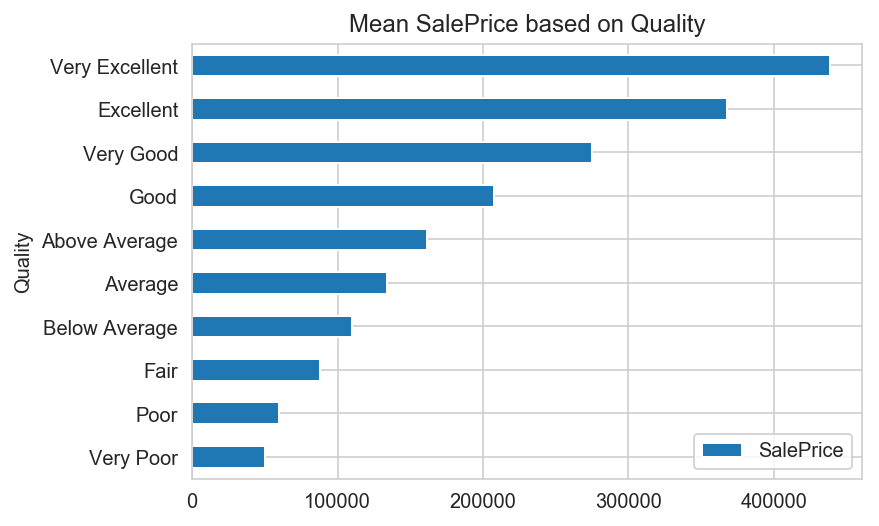

In [71]:
House_Qual.plot(kind='barh',title='Mean SalePrice based on Quality')

- From the quality alone, SalePrice has an obvious relationship with OverallQuality
- This could be that prices of houses are higher when the materials and finishing of the house is of higher grade

In [72]:
# Repeating for OverallCond

house.groupby('OverallCond')['SalePrice'].describe()

,count,mean,std,min,25%,50%,75%,max
OverallCond,,,,,,,,
1,1.0,61000.000000,NaN,61000.0,61000.0,61000.0,61000.0,61000.0
2,4.0,156233.000000,159009.277998,67000.0,74125.0,81750.0,163858.0,394432.0
3,24.0,104705.166667,43568.523308,39300.0,79000.0,90500.0,135725.0,200624.0
4,54.0,123622.055556,37254.070269,52500.0,93125.0,117750.0,147875.0,235000.0
5,819.0,203532.019536,84861.334122,55000.0,144000.0,185500.0,239742.5,745000.0
6,250.0,154225.684000,60897.965028,37900.0,124600.0,143000.0,172625.0,755000.0
7,204.0,158416.906863,53457.963634,79900.0,124250.0,145000.0,178000.0,402000.0
8,72.0,155651.736111,52375.144681,84500.0,125375.0,142500.0,170750.0,335000.0
9,22.0,216004.545455,96485.974689,110500.0,143500.0,176200.0,287875.0,475000.0


In [73]:
House_Cond = house.groupby('OverallCond')['SalePrice'].mean()
House_Cond = House_Cond.to_frame()
House_Cond

,SalePrice
OverallCond,
1,61000.000000
2,156233.000000
3,104705.166667
4,123622.055556
5,203532.019536
6,154225.684000
7,158416.906863
8,155651.736111
9,216004.545455


In [74]:
Cond = ['Very Poor', 'Poor', 'Fair', 'Below Average', 'Average', 'Above Average', 'Good', 'Very Good', 'Excellent']
House_Cond['Condition'] = Cond
House_Cond = House_Cond.set_index('Condition')

In [75]:
House_Cond

,SalePrice
Condition,
Very Poor,61000.000000
Poor,156233.000000
Fair,104705.166667
Below Average,123622.055556
Average,203532.019536
Above Average,154225.684000
Good,158416.906863
Very Good,155651.736111
Excellent,216004.545455


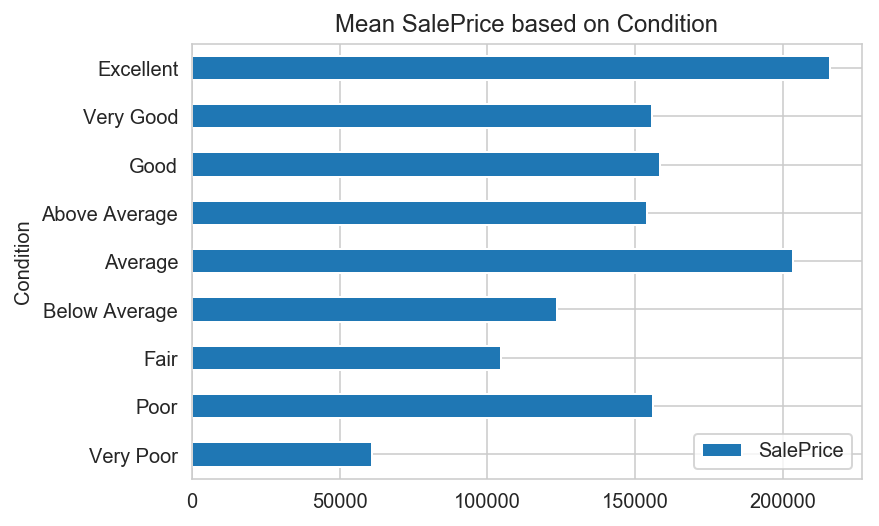

In [76]:
House_Cond.plot(kind='barh',title='Mean SalePrice based on Condition')

- It seems from the above that some outliers might have skewed the Average and Poor conditions.
- Overall the higher the condition of the house, the higher the SalePrice

In [77]:
# Setting up variables to run a RFE model for feature selection
renovatable_features = ['Utilities', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
                        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 
                        'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
                        'CentralAir', 'Electrical','KitchenQual', 'Functional', 'FireplaceQu',
                        'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscVal','YrSold'] # YrSold and SalePrice have been added in for filtering
# Creating the target
y_train = house[house['YrSold']<2010].iloc[:, [-1]].values
y_test = house[house['YrSold']>=2010].iloc[:, [-1]].values


X = house[renovatable_features]
X = pd.get_dummies(X)

X_train = X[house['YrSold']<2010]
X_test = X[house['YrSold']>=2010]



print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1278, 477) (172, 477)
(1278, 1) (172, 1)


In [78]:
# Standard scaling

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/ivanong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [79]:
# Run RFECV to check on the rennovatable features which are important to influencing SalePrice
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=8)
selector.fit(X_train, y_train)

print(selector.support_)
print(selector.ranking_)

/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [80]:
features_df = pd.DataFrame({'Features': X.columns,
                            'Important': selector.support_})

In [81]:
features_df['Important'] = features_df[['Important']].astype(str)

In [82]:
features_df[features_df['Important']=='True']

,Features,Important
368,MasVnrArea_796.0,True
400,BsmtCond_No_Bsmt,True
403,BsmtFinType1_ALQ,True
404,BsmtFinType1_BLQ,True
405,BsmtFinType1_GLQ,True
406,BsmtFinType1_LwQ,True
408,BsmtFinType1_Rec,True
409,BsmtFinType1_Unf,True


#### Obersevation:
- RFEcv has chosen the renovatable feature that most affect price
- Perhaps we should further look on how these individual features can affect the nominal value

In [87]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
optimal_lasso.fit(X_train, y_train)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=8)

print(lasso_scores)
print('Lasso model has a train score of:',(np.mean(lasso_scores)))

/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.81627842 0.79190944 0.74779742 0.79630054 0.76756757 0.76239014
 0.77681393 0.74636651]
Lasso model has a train score of: 0.7756779972975707


In [88]:
lasso.fit(X_train,y_train)
print('Lasso model has a test score of:',lasso.score(X_test,y_test))

Lasso model has a test score of: 0.7644190427114245


In [89]:
lasso_coefs = pd.DataFrame({'Features':X.columns,
                            'Coefficient':lasso.coef_})

lasso_coefs.sort_values('Coefficient', inplace=True, ascending=False)

# Showing top 10 which coefficients have been chosen by Lasso
lasso_coefs.head(10)

,Features,Coefficient
0,OverallQual,0.165090
393,BsmtQual_Ex,0.048438
395,BsmtQual_Gd,0.026543
423,HeatingQC_Ex,0.021106
435,KitchenQual_Ex,0.016871
1,OverallCond,0.015863
23,Exterior1st_BrkFace,0.015510
303,MasVnrArea_424.0,0.015062
419,Heating_GasW,0.014348
45,Exterior2nd_Plywood,0.013986


#### 2. How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.

- From the above table, the price is influenced by each feature via their respective coefficients
- High OverallQual, Good BsmtExposure and High KitchenQuality are the top 3 features which influence the price most
- Any features from the above list which lasso did not eliminate should generate a higher selling price than before
- Using the two models, the company should choose a property where the features have high coefficients and make renovation for high coefficients

#### 3. Investigate how much of the variance in price remaining is explained by these features.

In [90]:
renovatable_features = ['Utilities', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
                        'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 
                        'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
                        'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
                        'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscVal']


In [91]:
# To include YrSold for filtering and saleprice for train, test, split
df = house[renovatable_features + ['YrSold'] + ['SalePrice']]

In [92]:
df.head(5)

,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscVal,YrSold,SalePrice
0,AllPub,7,5,Gable,CompShg,BrkFace,196,Gd,TA,Gd,...,Typ,No_Fireplace,RFn,TA,TA,No_Pool,No_Fence,0,2008,208500
1,AllPub,6,8,Gable,CompShg,None,0,TA,TA,Gd,...,Typ,TA,RFn,TA,TA,No_Pool,No_Fence,0,2007,181500
2,AllPub,7,5,Gable,CompShg,BrkFace,162,Gd,TA,Gd,...,Typ,TA,RFn,TA,TA,No_Pool,No_Fence,0,2008,223500
3,AllPub,7,5,Gable,CompShg,None,0,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,No_Pool,No_Fence,0,2006,140000
4,AllPub,8,5,Gable,CompShg,BrkFace,350,Gd,TA,Gd,...,Typ,TA,RFn,TA,TA,No_Pool,No_Fence,0,2008,250000


In [93]:
df.dtypes

Utilities       object
OverallQual      int64
OverallCond      int64
RoofStyle       object
RoofMatl        object
MasVnrType      object
MasVnrArea      object
ExterQual       object
ExterCond       object
BsmtQual        object
BsmtCond        object
BsmtFinType1    object
BsmtFinType2    object
Heating         object
HeatingQC       object
CentralAir      object
Electrical      object
KitchenQual     object
Functional      object
FireplaceQu     object
GarageFinish    object
GarageQual      object
GarageCond      object
PoolQC          object
Fence           object
MiscVal          int64
YrSold           int64
SalePrice        int64
dtype: object

In [94]:
# Number of numerical and categorical features

categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

df_num = df[numerical_features]
df_cat = df[categorical_features]

Numerical features : 5
Categorical features : 23


In [95]:
df_cat = pd.get_dummies(df_cat, drop_first=True)
df = pd.concat([df_num, df_cat], axis=1)

In [96]:
df.shape

(1450, 424)

In [97]:
df.columns

Index(['OverallQual', 'OverallCond', 'MiscVal', 'YrSold', 'SalePrice',
       'Utilities_NoSeWa', 'RoofStyle_Gable', 'RoofStyle_Gambrel',
       'RoofStyle_Hip', 'RoofStyle_Mansard',
       ...
       'GarageCond_No_Garage', 'GarageCond_Po', 'GarageCond_TA', 'PoolQC_Fa',
       'PoolQC_Gd', 'PoolQC_No_Pool', 'Fence_GdWo', 'Fence_MnPrv',
       'Fence_MnWw', 'Fence_No_Fence'],
      dtype='object', length=424)

In [98]:
# Setting up predictors and target

X = df.drop('SalePrice',axis=1)
y = df.SalePrice.values

In [99]:
# Performing train, test, split

X_train = (X[df.YrSold < 2010]).values
X_test = (X[df.YrSold == 2010]).values

y_train = y[df.YrSold < 2010]
y_test = y[df.YrSold == 2010]

In [100]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [101]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)
print(lasso_scores)
print('Mean R2 score:',np.mean(lasso_scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[0.7793484  0.66711244 0.7517605  0.70528039 0.70253479 0.71281721
 0.66705203 0.7018568  0.58061826 0.76899228]
Mean R2 score: 0.7037373088996837


- From the above lasso model, the mean R2 score shows that 70% of the renovatable features can explain the variance of the previous model
- As explained in the previous model, features with high coefficients determined by Lasso and RFE can be renovated to fetch a higher selling price

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [102]:
# A:
house = pd.read_csv('./housing.csv')
print(house.SaleCondition.value_counts())

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64


In [103]:
# Creating a boolean as to show whether a sale was abnormal

house['Abnormal_Sale'] = house['SaleCondition'].map(lambda x: 1 if x =="Abnorml" else 0)
house.drop('SaleCondition', axis=1, inplace=True)

In [104]:
house.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [105]:
# Differentiate numerical features and categorical features

categorical_features = house.select_dtypes(include = ["object"]).columns
numerical_features = house.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
house_num = house[numerical_features]
house_cat = house[categorical_features]

Numerical features : 39
Categorical features : 42


In [106]:
house_cat = pd.get_dummies(house_cat, drop_first=True)
house = pd.concat([house_num, house_cat], axis = 1)

In [107]:
house.shape

(1460, 243)

In [108]:
# Setting up the predictor and target
X = house.drop('Abnormal_Sale', axis=1)
y = house.Abnormal_Sale

In [109]:
X.shape, y.shape

((1460, 242), (1460,))

##### Logsitic Regression Model

In [111]:
# Baseline Accuracy

1-np.mean(y)

0.9308219178082192

In [112]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ivanong/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
logreg = LogisticRegression(solver='lbfgs')

# 10-fold cross val
scores = cross_val_score(logreg, Xs, y, cv=10)
print(scores)
print(np.mean(scores))